# CausalNex first tutorial

In [35]:
import warnings
from causalnex.structure import StructureModel
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas

warnings.filterwarnings("ignore")  # silence warnings

DATA_DIR = Path('../inputs')
INPUT_CSV = DATA_DIR / 'causalnex/student/student-por.csv'

In [26]:
# Create an empty model
sm = StructureModel()

# Add some test edges
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

In [27]:
# Inspect the model edges
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

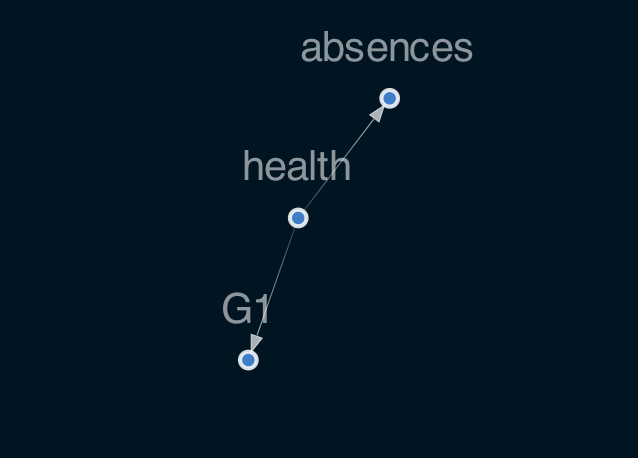

In [28]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [29]:
# Load in the data
data = pd.read_csv(INPUT_CSV, delimiter=';')
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [30]:
# Drop columns
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)

In [33]:
# Restructure the data for NOTEARS algorithm
struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


In [40]:
le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


In [47]:
sm = from_pandas(struct_data)

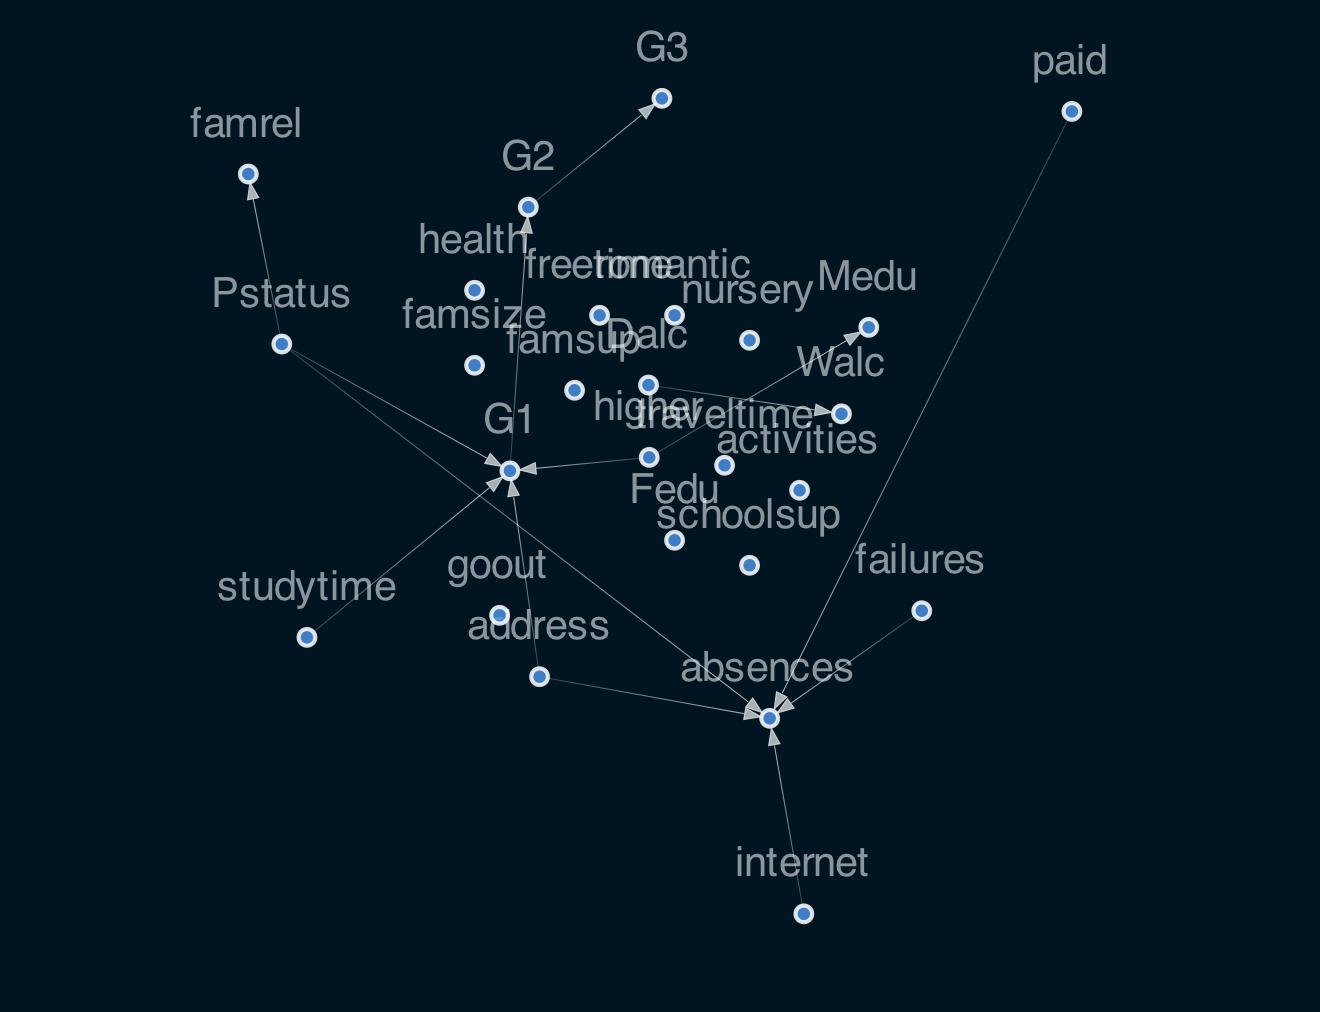

In [51]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

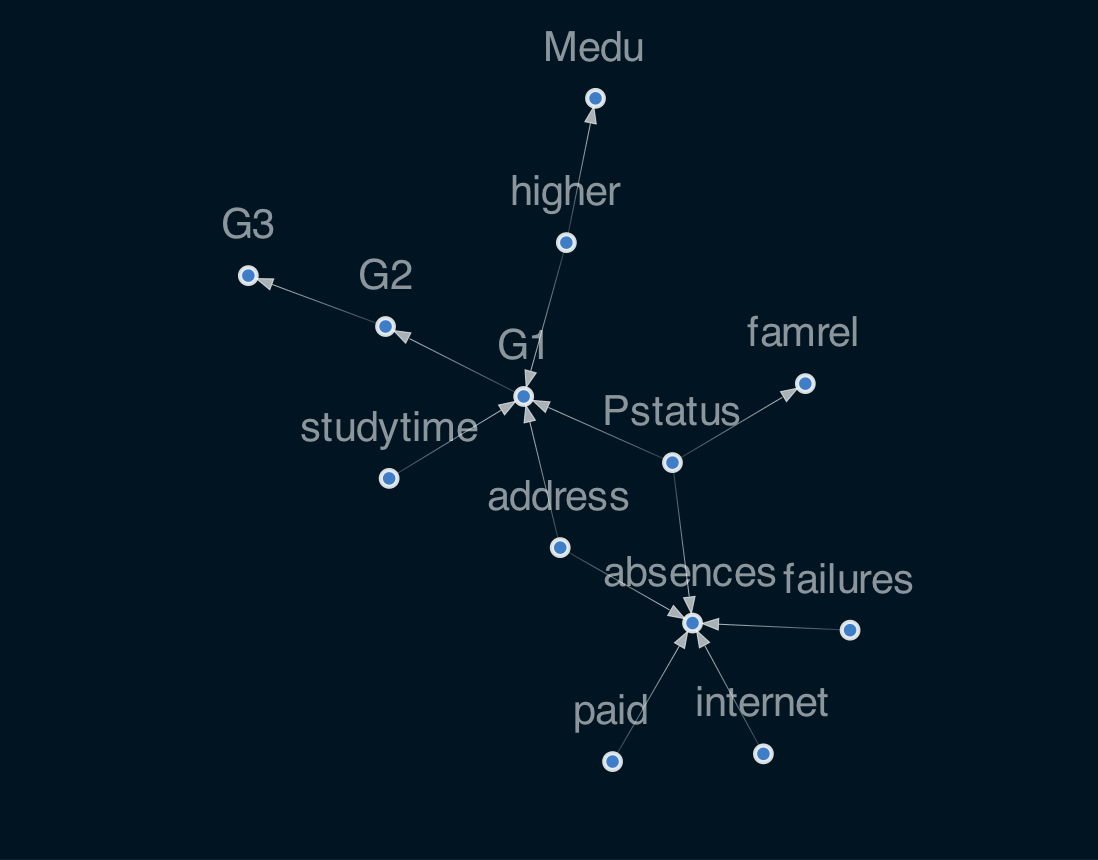

In [54]:
sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.45"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [55]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

In [56]:
discretised_data = data.copy()

data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == [0]
                else 'have-failure' for v in data_vals['failures']}
studytime_map = {v: 'short-studytime' if v in [1,2]
                 else 'long-studytime' for v in data_vals['studytime']}

In [57]:
discretised_data["failures"] = discretised_data["failures"].map(failures_map)
discretised_data["studytime"] = discretised_data["studytime"].map(studytime_map)

In [58]:
from causalnex.discretiser import Discretiser

discretised_data["absences"] = Discretiser(method="fixed",
                          numeric_split_points=[1, 10]).transform(discretised_data["absences"].values)
discretised_data["G1"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["G1"].values)
discretised_data["G2"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["G2"].values)
discretised_data["G3"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["G3"].values)

In [59]:
absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}

G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

discretised_data["absences"] = discretised_data["absences"].map(absences_map)
discretised_data["G1"] = discretised_data["G1"].map(G1_map)
discretised_data["G2"] = discretised_data["G2"].map(G2_map)
discretised_data["G3"] = discretised_data["G3"].map(G3_map)

In [60]:
# Split 90% train and 10% test
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

In [61]:
bn = bn.fit_node_states(discretised_data)

In [62]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [63]:
bn.cpds["G1"]

Pstatus                A                                                 \
address                R                                                  
higher                no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                0.75             0.5       0.333333        0.222222   
Pass                0.25             0.5       0.666667        0.777778   

Pstatus                                                                  \
address                U                                                  
higher                no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail            0.333333        0.333333          0.125          0.1875   
Pass            0.666667        0.666667          0.875          0.8125   

Pstatus                T                                                 \
address                R                                                  
higher                no                            yes                   
studytime long-studytime short-studytime long-studytime short-studytime   
G1                                                                        
Fail                 0.5            0.84       0.085714        0.327273   
Pass                 0.5            0.16       0.914286        0.672727   

Pstatus                                                                  
address                U                                                 
higher                no                            yes                  
studytime long-studytime short-studytime long-studytime short-studytime  
G1                                                                       
Fail                 0.6         0.69697           0.08        0.191057  
Pass                 0.4         0.30303           0.92        0.808943

In [64]:
discretised_data.loc[18, discretised_data.columns != 'G1']

address                     U
famsize                   GT3
Pstatus                     T
Medu                        3
Fedu                        2
traveltime                  1
studytime     short-studytime
failures         have-failure
schoolsup                  no
famsup                    yes
paid                      yes
activities                yes
nursery                   yes
higher                    yes
internet                  yes
romantic                   no
famrel                      5
freetime                    5
goout                       5
Dalc                        2
Walc                        4
health                      5
absences          Low-absence
G2                       Fail
G3                       Fail
Name: 18, dtype: object

In [65]:
predictions = bn.predict(discretised_data, "G1")

In [66]:
print(f"The prediction is '{predictions.loc[18, 'G1_prediction']}'")

The prediction is 'Pass'


In [67]:
print(f"The ground truth is '{discretised_data.loc[18, 'G1']}'")

The ground truth is 'Fail'


In [68]:
from causalnex.evaluation import classification_report

classification_report(bn, test, "G1")

{'G1_Fail': {'precision': 1.0,
  'recall': 0.16666666666666666,
  'f1-score': 0.2857142857142857,
  'support': 12},
 'G1_Pass': {'precision': 0.8412698412698413,
  'recall': 1.0,
  'f1-score': 0.9137931034482758,
  'support': 53},
 'accuracy': 0.8461538461538461,
 'macro avg': {'precision': 0.9206349206349207,
  'recall': 0.5833333333333334,
  'f1-score': 0.5997536945812807,
  'support': 65},
 'weighted avg': {'precision': 0.8705738705738706,
  'recall': 0.8461538461538461,
  'f1-score': 0.7978400909435392,
  'support': 65}}

In [69]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "G1")
print(auc)

0.893491124260355
